# Slicing

In [1]:
# import
import sys
sys.path.append('../')

import logging
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tissue_clustering import find_DBSCAN_clusters
from loss import loss_fct
from visualization_utils import show_clusters

# Set up the logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

In [15]:
# Visualize an image slice using simpleITK
import SimpleITK as sitk

# Load the image data
volume = sitk.ReadImage('..\MRI\Labels\labels_00001.nii')
img_array = sitk.GetArrayFromImage(volume)
img_array.shape

(61, 864, 606)

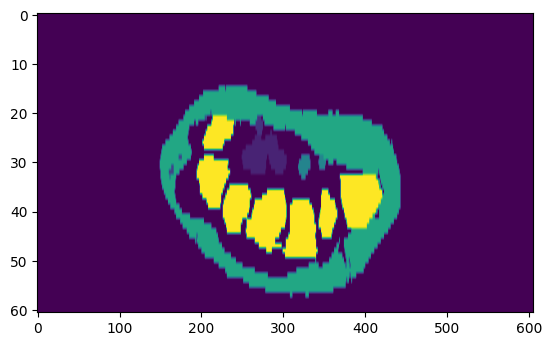

In [16]:

# Take a 2D image slice
slice_num = 670
slice = img_array[:, slice_num, :]
plt.imshow(slice, aspect=6)
plt.show()

In [4]:
volume_size = volume.GetSize()
img_size = img_array.shape

print(f" {volume_size=},\n {img_size=}")

 volume_size=(606, 864, 61),
 img_size=(61, 864, 606)


In [5]:
# Euler transformation
# Rotation is defined by three rotations around z1, x2, z2 axis
th_z1 = np.deg2rad(20)
th_x2 = np.deg2rad(0)

# Translation vector
o = np.array(volume.GetOrigin())

# transformation simplified at z2=0 since this rotation is never performed
eul_tr = np.array([ [np.cos(th_z1), -np.sin(th_z1)*np.cos(th_x2),  np.sin(th_z1)*np.sin(th_x2), o[0]],
                    [np.sin(th_z1),  np.cos(th_z1)*np.cos(th_x2), -np.cos(th_z1)*np.sin(th_x2), o[1]+140],
                    [0,              np.sin(th_x2),                np.cos(th_x2),               o[2]],
                    [0,              0,                            0,                           1]])


In [6]:
# Define plane's coordinate system
e1 = eul_tr[0][:3] # x-coordinate of image plane
e2 = eul_tr[1][:3] # y-coordinate of image plane
e3 = eul_tr[2][:3] # normal vector of image plane
origin = eul_tr[:, -1:].flatten()[:3] # origin of the image plane

print(f" {e1=},\n {e2=},\n {e3=},\n {origin=}")

# Direction for the resampler will be (e1, e2, e3) flattened
direction = np.stack([e1, e2, e3], axis=0).flatten()
print(f" {direction=}")

 e1=array([ 0.93969262, -0.34202014,  0.        ]),
 e2=array([ 0.34202014,  0.93969262, -0.        ]),
 e3=array([0., 0., 1.]),
 origin=array([-74.90050507,  33.1584549 , -30.        ])
 direction=array([ 0.93969262, -0.34202014,  0.        ,  0.34202014,  0.93969262,
       -0.        ,  0.        ,  0.        ,  1.        ])


In [7]:
# Define the size and resolution of the output image
# height of the image plane: original z size divided by the z component of the normal vector
# (cosine of the angle between the normal vector and the z axis: x-rotation)
h = int(abs(volume_size[2]//e3[2]))
# width of the image plane: original x size divided by the x component of the normal vector
# (cosine of the angle between the normal vector and the x axis: z-rotation) 
w = int(abs(volume_size[0]//e1[0]))


print(f" {h=},\n {w=}") 

 h=61,
 w=644


In [8]:
# Use SimpleITK's resampler
resampler = sitk.ResampleImageFilter()
# Extract properties from the SimpleITK Image
spacing = volume.GetSpacing()

# use reference image
# resampler.SetReferenceImage(volume)
resampler.SetOutputDirection(direction.tolist())
resampler.SetOutputOrigin(origin.tolist())
resampler.SetOutputSpacing(spacing)
resampler.SetSize((w, 3, h))
resampler.SetInterpolator(sitk.sitkNearestNeighbor)

In [9]:
# Resample the volume on the arbitrary plane
sliced_volume = resampler.Execute(volume)

# Convert the image to a numpy array
sliced_img = sitk.GetArrayFromImage(sliced_volume)
# print value range of slice
print(f"Slice value range: {np.min(sliced_img)} - {np.max(sliced_img)}")

sitk.WriteImage(sliced_volume, "../outputs/sliced_volume.nii.gz")

Slice value range: 0 - 20


In [10]:
sliced_volume_size = sliced_volume.GetSize()
sliced_img_size = sliced_img.shape

print(f" {sliced_volume_size=},\n {volume_size=},\n {sliced_img_size=},\n {img_size=}")

 sliced_volume_size=(644, 3, 61),
 volume_size=(606, 864, 61),
 sliced_img_size=(61, 3, 644),
 img_size=(61, 864, 606)


[-74.90050507  33.1584549  -30.        ]
(0, 565, 0)


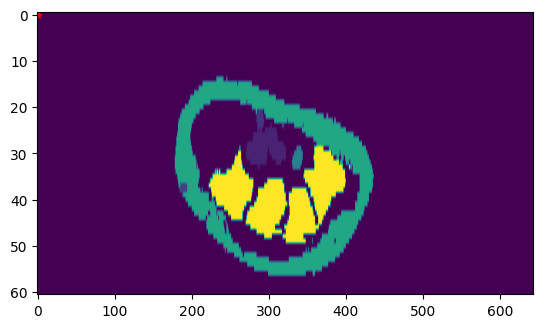

In [11]:
print(origin)
origin_idx = volume.TransformPhysicalPointToIndex(origin)
print(origin_idx)
slice = sliced_img[:, 0, :]
plt.imshow(slice, aspect=6)
plt.scatter(origin_idx[0], origin_idx[2], c='r', marker='*', s=20)
plt.show()

In [12]:
def slice_volume(z_rotation: float, x_rotation: float, translation: np.ndarray[3], volume: sitk.Image):
    """
    Slice a 3D volume with arbitrary rotation and translation
    :param z_rotation: rotation around z-axis in degrees
    :param x_rotation: rotation around x-axis in degrees
    :param translation: translation vector
    :param volume: 3D volume to be sliced
    :return: Euler transformation matrix and the sliced volume
    """

    # Euler transformation
    # Rotation is defined by three rotations around z1, x2, z2 axis
    th_z1 = np.deg2rad(z_rotation)
    th_x2 = np.deg2rad(x_rotation)

    o = np.array(volume.GetOrigin())
    t = translation

    # transformation simplified at z2=0 since this rotation is never performed
    eul_tr = np.array([ [np.cos(th_z1), -np.sin(th_z1)*np.cos(th_x2),  np.sin(th_z1)*np.sin(th_x2), o[0]+t[0]],
                        [np.sin(th_z1),  np.cos(th_z1)*np.cos(th_x2), -np.cos(th_z1)*np.sin(th_x2), o[1]+t[1]],
                        [0,              np.sin(th_x2),                np.cos(th_x2),               o[2]+t[2]],
                        [0,              0,                            0,                           1]])

    # Define plane's coordinate system
    e1 = eul_tr[0][:3]
    e2 = eul_tr[1][:3]
    e3 = eul_tr[2][:3]
    img_o = eul_tr[:, -1:].flatten()[:3] # origin of the image plane

    direction = np.stack([e1, e2, e3], axis=0).flatten()

    resampler = sitk.ResampleImageFilter()
    spacing = volume.GetSpacing()
    volume_size = volume.GetSize()

    # Define the size of the output image
    # height of the image plane: original z size divided by cosine of x-rotation
    h = int(abs(volume_size[2]//e3[2]))
    # width of the image plane: original x size divided by cosine of z-rotation
    w = int(abs(volume_size[0]//e1[0]))

    resampler.SetOutputDirection(direction.tolist())
    resampler.SetOutputOrigin(img_o.tolist())
    resampler.SetOutputSpacing(spacing)
    resampler.SetSize((w, 3, h))
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)

    # Resample the volume on the arbitrary plane
    sliced_volume = resampler.Execute(volume)

    return eul_tr, sliced_volume

Slice value range: 0 - 20


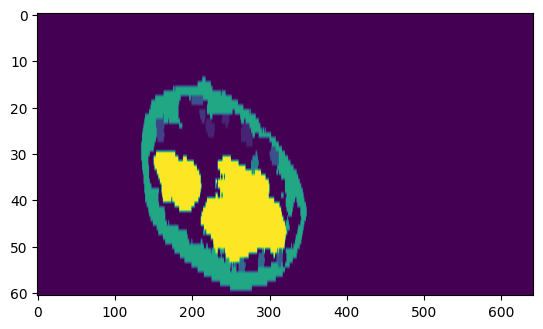

In [13]:
_, sliced_volume = slice_volume(z_rotation=19.3, x_rotation=0, translation=np.array([0, 167, 0]), volume=volume)
sliced_img = sitk.GetArrayFromImage(sliced_volume)
print(f"Slice value range: {np.min(sliced_img)} - {np.max(sliced_img)}")
sitk.WriteImage(sliced_volume, "../outputs/sliced_volume.nii.gz")

slice = sliced_img[:, 0, :]
plt.imshow(slice, aspect=6)
plt.show()

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


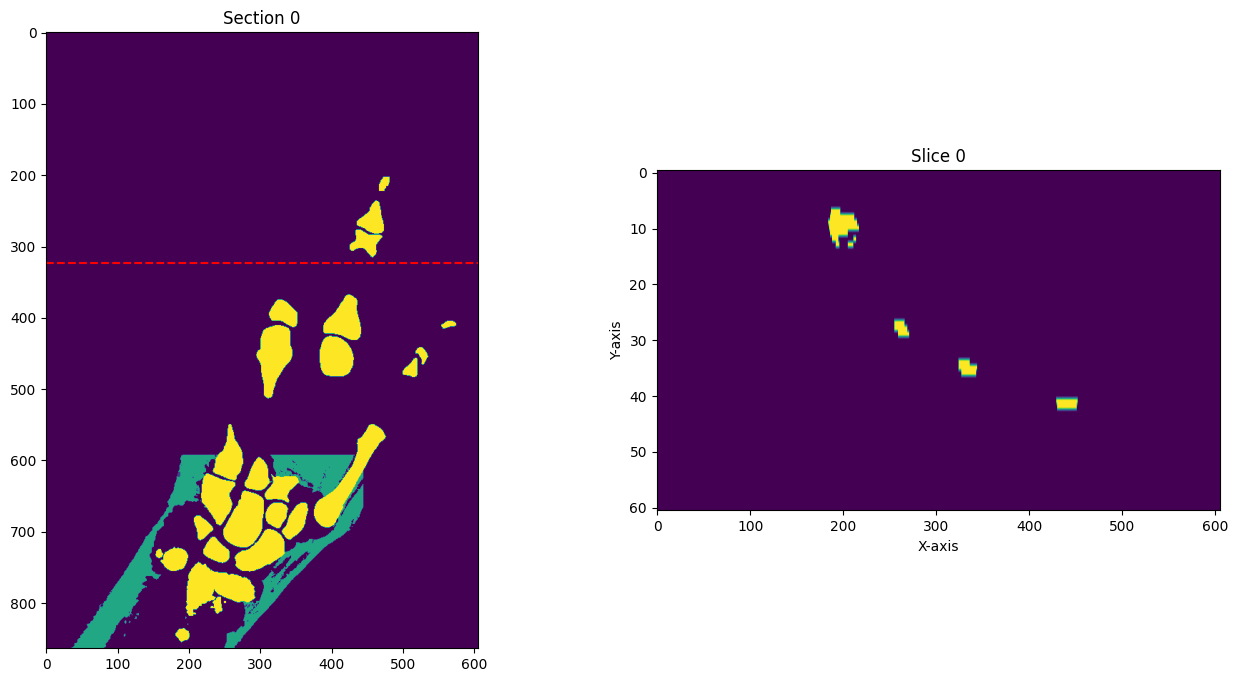

In [14]:
from matplotlib.animation import FuncAnimation

# t = [160, 155, 150, 148, 146, 142,  140, 140, 115, 120, 125, 125, 130, 130, 135, 138, 140, 140,  140]
# z = [  0,  -5,   0,   0,   5,  15, 19.3, -10,   0,   0,   0,   5,   -8,  8,   0, -10, -10,  10, 19.3]

# For linear sweep demonstration
t = np.arange(80, 180.5, 2.5)
z = np.zeros_like(t)

tissues = { "bones": 20,
            "tendins": 2,
            "ulnar": 3,}

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

center_x = img_array.shape[2] // 2  # Calculate x-coordinate of the center
# Sample functions for demonstration
def linear_function(x, m, b):
  return m * x + b

# Subplot 1: Image with dashed line
ax1.imshow(img_array[40,:,:])
x_dash = np.arange(img_array.shape[2])
b = volume.TransformPhysicalPointToIndex([o[0], o[1]+t[0], o[2]])[1]
y_dash = linear_function(x_dash, np.tan(np.deg2rad(z[0])), b)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
ax1.set_title(f"Section {0}")
line = ax1.plot(x_dash, y_dash, linestyle="--", color="red")[0]

# Subplot 2: Function image
_, sliced_volume = slice_volume(z_rotation=z[0], x_rotation=0, translation=np.array([0, t[0], 0]), volume=volume)
sliced_img = sitk.GetArrayFromImage(sliced_volume)
slice = sliced_img[:, 0, :]
ax2.set_title(f"Slice {0}")
slice_img = ax2.imshow(slice, aspect=6)

# Loop function
def update_image(i):
  
  b = volume.TransformPhysicalPointToIndex([o[0], o[1]+t[i], o[2]])[1]
  y_dash = linear_function(x_dash, np.tan(np.deg2rad(z[i])), b)
  ax1.set_title(f"Section {i}")
  line.set_ydata(y_dash)

  _, sliced_volume = slice_volume(z_rotation=z[i], x_rotation=0, translation=np.array([0, t[i], 0]), volume=volume)
  sliced_img = sitk.GetArrayFromImage(sliced_volume)
  slice = sliced_img[:, 0, :]
  ax2.set_title(f"Slice {i}")
  slice_img.set_data(slice)
  return (line, slice_img)

animation = FuncAnimation(fig=fig, func=update_image, frames=len(t), interval=200)
animation.save('../outputs/animation.gif', writer='Pillow', fps=2)

plt.rcParams["animation.html"] = "jshtml"
animation